In [1]:
from fastai.data.external import untar_data, URLs
from fastai.vision.data import imagenet_stats
from fastcore.xtras import Path

dataset_path = untar_data(URLs.PETS)
dataset_path.ls()

(#2) [Path('/home/jcarnero/.fastai/data/oxford-iiit-pet/annotations'),Path('/home/jcarnero/.fastai/data/oxford-iiit-pet/images')]

In [2]:
imagenet_stats

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [3]:
from torch import nn
from torchvision.transforms import CenterCrop, RandomResizedCrop, ToTensor, Normalize

train_transforms = nn.Sequential(
    RandomResizedCrop((224,224)),
    Normalize(*imagenet_stats)
)

valid_transforms = nn.Sequential(
    CenterCrop((224,224)),
    Normalize(*imagenet_stats)
)

In [4]:
import re
from PIL import Image
from torch.utils.data import Dataset

# This example is highly based on the work of Sylvain Gugger
# for the Accelerate notebook example which can be found here: 
# https://github.com/huggingface/notebooks/blob/main/examples/accelerate_examples/simple_cv_example.ipynb
class PetsDataset(Dataset):
    "A basic dataset that will return a tuple of (image, label)"
    def __init__(self, filenames:list, transforms:nn.Sequential, label_to_int:dict):
        self.filenames = filenames
        self.transforms = transforms
        self.label_to_int = label_to_int
        self.to_tensor = ToTensor()
    
    def __len__(self):
        return len(self.filenames)
    
    def apply_x_transforms(self, filename):
        image = Image.open(filename).convert("RGB")
        tensor_image = self.to_tensor(image)
        return self.transforms(tensor_image)
    
    def apply_y_transforms(self, filename):
        label = re.findall(r"^(.*)_\d+\.jpg$", filename.name)[0].lower()
        return self.label_to_int[label]
    
    def __getitem__(self, index):
        filename = self.filenames[index]
        x = self.apply_x_transforms(filename)
        y = self.apply_y_transforms(filename)
        return (x,y)

In [5]:
label_pat = r"^(.*)_\d+\.jpg$"
filenames = (dataset_path/'images').ls(file_exts=".jpg")

In [6]:
labels = filenames.map(
    lambda x: re.findall(label_pat, x.name)[0].lower()
).unique()

In [7]:
labels

(#37) ['basset_hound','boxer','staffordshire_bull_terrier','great_pyrenees','japanese_chin','english_setter','american_bulldog','russian_blue','maine_coon','persian'...]

In [8]:
label_to_int = {index:key for key, index in enumerate(labels)}
label_to_int.keys(), label_to_int["siamese"]

(dict_keys(['basset_hound', 'boxer', 'staffordshire_bull_terrier', 'great_pyrenees', 'japanese_chin', 'english_setter', 'american_bulldog', 'russian_blue', 'maine_coon', 'persian', 'samoyed', 'abyssinian', 'siamese', 'wheaten_terrier', 'sphynx', 'birman', 'american_pit_bull_terrier', 'miniature_pinscher', 'bengal', 'english_cocker_spaniel', 'bombay', 'keeshond', 'ragdoll', 'shiba_inu', 'havanese', 'leonberger', 'saint_bernard', 'german_shorthaired', 'egyptian_mau', 'scottish_terrier', 'pug', 'beagle', 'chihuahua', 'british_shorthair', 'yorkshire_terrier', 'newfoundland', 'pomeranian']),
 12)

In [9]:
import numpy as np
shuffled_indexes = np.random.permutation(len(filenames))
split = int(0.8 * len(filenames))
train_indexes, valid_indexes = (
    shuffled_indexes[:split], shuffled_indexes[split:]
)

In [10]:
train_fnames = filenames[train_indexes]
valid_fnames = filenames[valid_indexes]

In [11]:
train_dataset = PetsDataset(
    train_fnames,
    train_transforms,
    label_to_int
)

valid_dataset = PetsDataset(
    valid_fnames,
    valid_transforms,
    label_to_int
)

In [12]:
x,y = train_dataset[0]
x.shape, y

(torch.Size([3, 224, 224]), 12)

In [13]:
from torch.utils.data import DataLoader

In [14]:
train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    drop_last=True,
    batch_size=64
)

In [15]:
valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=128
)

In [16]:
from fastai.data.core import DataLoaders

In [17]:
dls = DataLoaders(train_dataloader, valid_dataloader)

In [18]:
from torchvision.models import resnet34

model = resnet34(pretrained=True)

/home/jcarnero/.miniconda3/envs/fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/jcarnero/.miniconda3/envs/fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
model.fc = nn.Linear(512, 37, bias=True)

In [20]:
model.fc

Linear(in_features=512, out_features=37, bias=True)

In [21]:
list(model.children())[-1]

Linear(in_features=512, out_features=37, bias=True)

In [22]:
for layer in list(model.children())[:-1]:
    if hasattr(layer, "requires_grad_"):
        layer.requires_grad_(False)

In [23]:
from torch.optim import AdamW

In [24]:
from functools import partial
from fastai.optimizer import OptimWrapper

In [25]:
opt_func = partial(OptimWrapper, opt=AdamW)

In [26]:
from fastai.losses import CrossEntropyLossFlat
from fastai.metrics import accuracy
from fastai.learner import Learner
from fastai.callback.schedule import Learner

In [27]:
model.cuda();

In [28]:
learn = Learner(
    dls, 
    model, 
    opt_func=opt_func, 
    loss_func=CrossEntropyLossFlat(), 
    metrics=accuracy
)

SuggestedLRs(valley=0.0005754399462603033)

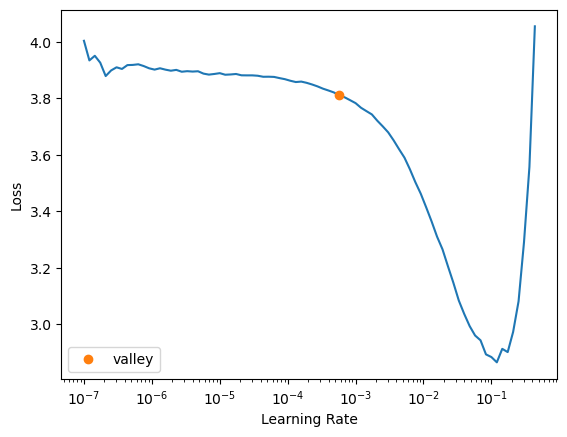

In [29]:
learn.lr_find()

In [30]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.869933,1.698315,0.701624,00:20
1,1.377559,0.655759,0.853857,00:20
2,0.891769,0.494700,0.883627,00:20
3,0.755402,0.451185,0.895805,00:20
4,0.692931,0.451014,0.895805,00:20


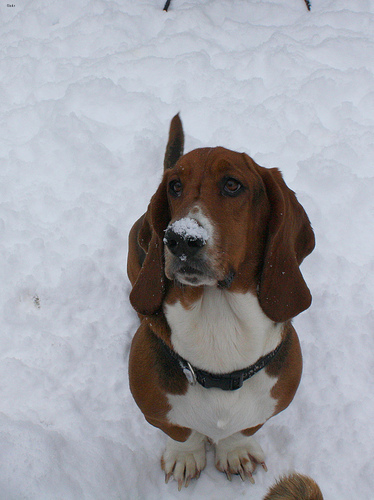

In [31]:
im = Image.open(filenames[0])
im

In [32]:
net = learn.model

In [33]:
tfm_x = valid_transforms(ToTensor()(im))
tfm_x = tfm_x.unsqueeze(0); tfm_x.shape

torch.Size([1, 3, 224, 224])

In [34]:
import torch
net.eval()
with torch.no_grad():
    preds = net(tfm_x.cuda())
pred = preds.argmax(dim=-1)[0]
label = list(label_to_int.keys())[pred]
pred, label

(tensor(0, device='cuda:0'), 'basset_hound')

Test our own predict

In [35]:
%%capture
%cd ..

In [36]:
from pets.pytorch.learner import predict

In [39]:
predict("pytorch", im)

/home/jcarnero/.miniconda3/envs/fastai/lib/python3.10/site-packages/fastai/learner.py:58: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


(tensor(0, device='cuda:0'), 'basset_hound')